<a href="https://colab.research.google.com/github/MohamedDerri/Machine-Deep-Learning-Enchantment-My-90-Day-Challenge-to-Master-the-Art-of-AI/blob/master/pneumothorax_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

#@ INITIALIZATION: 
#enables automatic reloading of Python modules that are imported into the notebook, 
#so that any changes made to the module are automatically reloaded without having to restart the kernel.
%reload_ext autoreload
#display Matplotlib graphs and charts directly in the notebook, rather than in a separate window.
%matplotlib inline


#!conda install pyarrow
#!pip install pydicom kornia opencv-python scikit-image nbdev

In [ ]:
!pip install -r https://raw.githubusercontent.com/MohamedDerri/Machine-Deep-Learning-Enchantment-My-90-Day-Challenge-to-Master-the-Art-of-AI/master/requirements.txt

In [ ]:
!pip install Pillow==8.3.2


from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *


import pydicom

import pandas as pd

In [5]:
# getting the dicom files 
'''untar_data: This is a PyTorch utility function used to download and extract a dataset from a URL. 
It will automatically download the dataset from the internet if it has not been previously downloaded and cached on your system.
URLs.SIIM_SMALL: This is a URL pointing to a compressed archive file containing a small version of the SIIM-ACR Pneumothorax 
Segmentation dataset. The dataset contains chest X-rays with and without pneumothorax, a condition in which air 
leaks into the space between the lung and the chest wall, causing the lung to collapse.'''

from numpy import shape


pneumothorax_source = untar_data(URLs.SIIM_SMALL) 
print(URLs.SIIM_SMALL)
print(pneumothorax_source)

# get the path to the DICOM fieles by appending 'train' to the source folder path, items is a list of paths
items = get_dicom_files(pneumothorax_source/f"train/")
print(shape(items))


#Next, we split the items list into a train trn and validation val list using the RandomSplitter function:

train, validation = RandomSplitter()(items)

'''Pydicom is a python package for parsing DICOM files, making it easier to access the header of the DICOM as well as
coverting the raw pixel_data into pythonic structures for easier manipulation. fastai.medical.imaging uses pydicom.dcmread 
to load the DICOM file.'''
patient = 190
xray_sample = items[patient].dcmread()
xray_sample 

https://s3.amazonaws.com/fast-ai-imagelocal/siim_small.tgz
/root/.fastai/data/siim_small
(250,)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.12814.1517875241.978596
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.12814.1517875241.978596
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [6]:
# Inspecting the Pixel. 
xray_sample.PixelData[:20]


b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0tn\x02\x00\xff\xd8\xff\xdb'

In [7]:

'''Because of the complexity in interpreting PixelData, pydicom provides an easy way to get it in a convenient form: 
pixel_array which returns a numpy.ndarray containing the pixel data:'''
xray_sample.pixel_array, xray_sample.pixel_array.shape    # Inspecting the Pixel. 

(array([[  0,   0,   0, ..., 254, 254, 255],
        [  0,   0,   0, ..., 255, 254, 255],
        [  0,   0,   0, ..., 255, 255, 255],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 (1024, 1024))

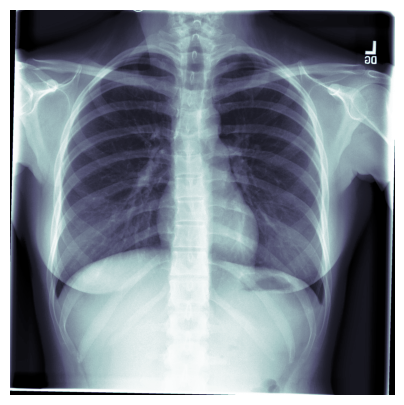

In [8]:
xray_sample.show()

In [9]:
'''transform all the dicom images into a pandas dataframe with features as columns'''
dicom_dataframe = pd.DataFrame.from_dicoms(items)
dicom_dataframe[:4]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,...,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.13262.1517875244.406985,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000191.dcm,0,248,132.395108,68.712143,0.238997
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.14008.1517875249.107636,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000013.dcm,0,255,156.819593,60.655749,0.119986
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.1512.1517875168.175004,19010101,000000.00,,CR,WSD,(),view: AP,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000219.dcm,0,255,110.374286,54.129446,0.275397
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.6207.1517875197.39635,19010101,000000.00,,CR,WSD,(),view: AP,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000068.dcm,0,243,89.828911,61.422476,0.333747


In [10]:
'''load the target results located in labels.csv'''
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()
print(df.columns)

Index(['file', 'label'], dtype='object')


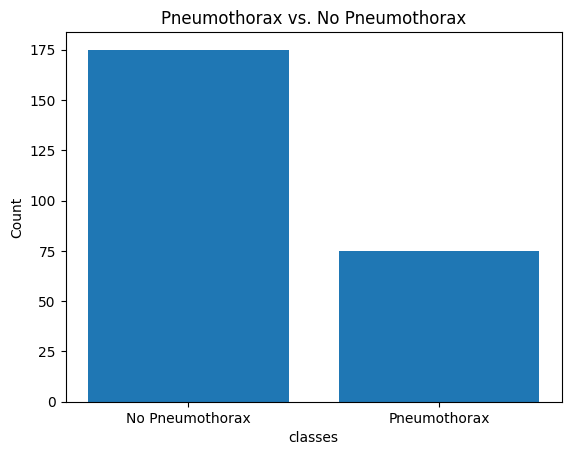

In [11]:

import matplotlib.pyplot as plt

# Count the number of images with and without pneumothorax
counts = df["label"].value_counts()

# Create a bar chart of the results
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values)
ax.set_title("Pneumothorax vs. No Pneumothorax")
ax.set_xlabel("classes")
ax.set_ylabel("Count")
plt.show()


In [12]:


pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats, cuda=False)]
)

df = pd.read_csv(pneumothorax_source/f"labels.csv")
dls = pneumothorax.dataloaders(df.values, num_workers=0)


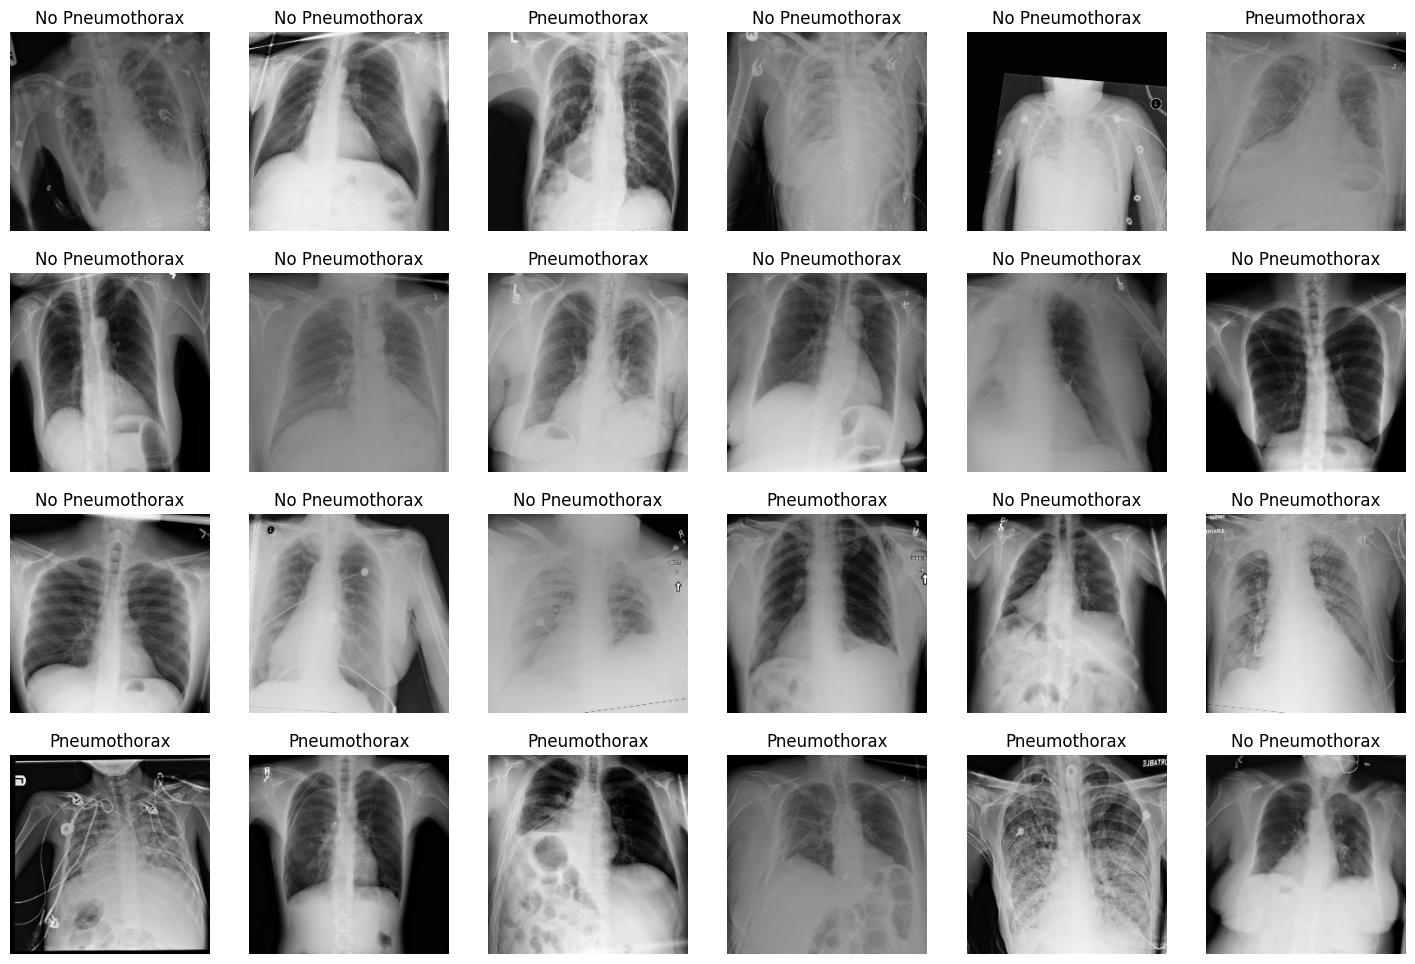

In [13]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=24)

In [14]:
'''vision_learner: This function creates a Learner object specialized for computer vision tasks. 
It takes in the dataloaders object (dls), the architecture of the model (resnet34), and any evaluation metrics to use during training (metrics).
dls: This is the dataloaders object that we created earlier using the DataBlock API. 
It contains the training and validation data, and any data augmentation or normalization transformations that we specified.
resnet34: This is the architecture of the model we want to use. In this case, 
we're using the ResNet34 convolutional neural network architecture, which is a popular choice for image classification tasks.
metrics: This argument specifies the evaluation metric that we want to use during training. In this case,
 we're using the accuracy metric, which measures the proportion of correct predictions made by the model.'''

learn = vision_learner(dls, resnet34, metrics=accuracy)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 78.5MB/s]


In [15]:
learn.loss_func #the loss function chosen automatically by fastai if not specified

FlattenedLoss of CrossEntropyLoss()

SuggestedLRs(valley=0.0012022644514217973)

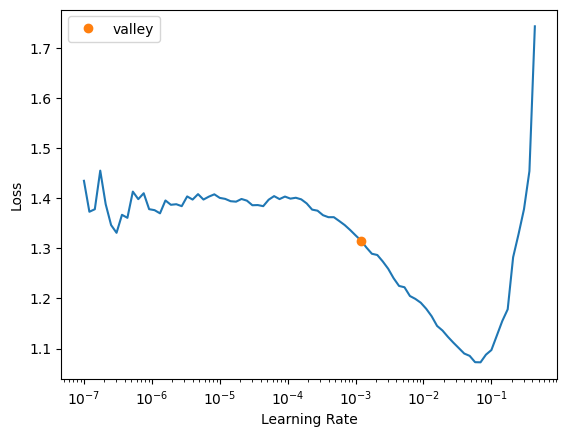

In [16]:
'''learn.lr_find() is a method in the fastai library that helps to determine an appropriate 
learning rate to use during training. It works by training the model for a few epochs while gradually 
increasing the learning rate, and then plotting the loss against the learning rate on a logarithmic scale. 
This plot helps to identify the learning rate range where the loss is decreasing most rapidly, 
which is usually a good choice for training the model.

The lr_find() method requires training because it needs to evaluate the model's loss at different 
learning rates to create the plot. However, the training during lr_find() is usually short,
typically just a few epochs with a small portion of the data. This is because lr_find() is not meant
to train the model to convergence, but rather to find a good range of learning rates to use in the training.

After finding an appropriate learning rate range with lr_find(), we typically retrain the model 
using the same data and a longer training schedule, such as many epochs or with more data, 
while using the learning rate we found as the starting point. This is done to 
optimize the model's weights and parameters over many iterations while gradually reducing 
the learning rate to allow the model to converge to a good solution.'''

#find the learning rate
learn.lr_find()

In [17]:
#training the model for one epoch (one pass through the entire dataset) 
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.352037,0.989766,0.700000,01:14
1,1.289055,0.872450,0.700000,01:14
2,1.167226,0.940911,0.720000,01:13
3,1.121732,0.863405,0.700000,01:15
4,1.048881,0.782017,0.700000,01:18
5,1.004990,0.749612,0.680000,01:13
6,0.949306,0.708465,0.700000,01:13
7,0.937127,0.666810,0.700000,01:14
8,0.914052,0.628546,0.700000,01:14
9,0.903354,0.609613,0.720000,01:14


In [18]:
learn2 = cnn_learner(dls, resnet34, metrics=accuracy) # i will train the model using cnn instead of vision learner and compare 


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.002511886414140463)

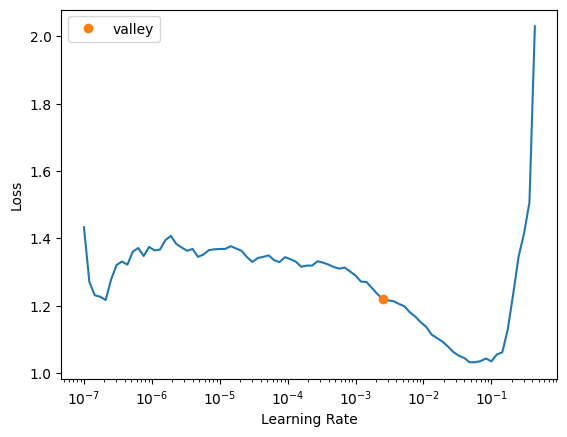

In [19]:
learn2.lr_find() 

In [20]:
learn2.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.273916,1.791639,0.380000,01:14
1,1.187784,0.952361,0.480000,01:14
2,1.171621,0.793508,0.640000,01:13
3,1.153212,0.880653,0.580000,01:13
4,1.075185,0.830557,0.580000,01:13
5,1.014668,0.788660,0.620000,01:14
6,0.956373,0.793753,0.640000,01:17
7,0.926362,0.800256,0.660000,01:13
8,0.926287,0.739965,0.660000,01:14
9,0.923985,0.747243,0.660000,01:14


In [21]:
learn.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")


('No Pneumothorax', tensor(0), tensor([0.7075, 0.2925]))

In [22]:
learn2.predict(pneumothorax_source/f"train/Pneumothorax/000004.dcm")

('No Pneumothorax', tensor(0), tensor([0.6703, 0.3297]))

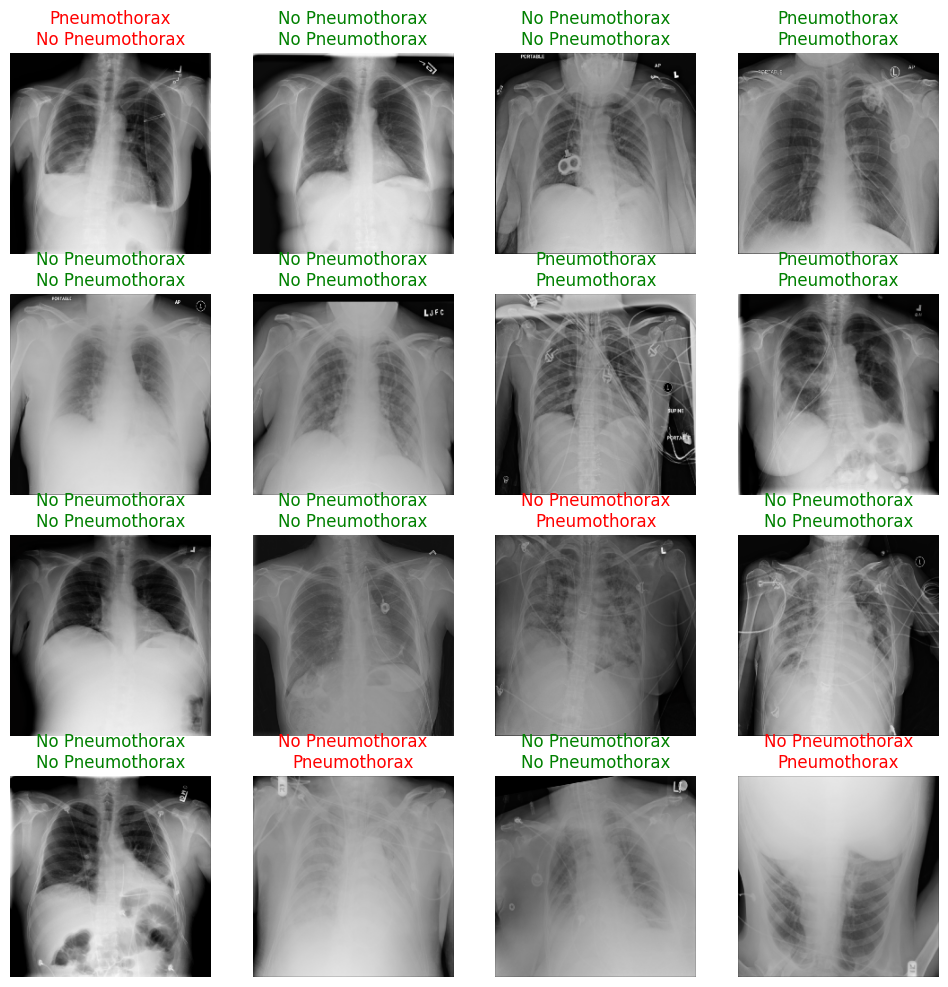

In [23]:
# inspecting
'''The learn.tta() method is used for Test Time Augmentation (TTA).
It is a technique used in deep learning for improving the accuracy of predictions
by applying data augmentation techniques at test time.

The idea is to create multiple versions of each test image by applying different
transformations to the image, such as flipping, rotating, and zooming. Then,
the model makes predictions on each of the transformed images, and the final prediction
is obtained by taking an average of the predictions.

The learn.tta() method applies TTA to the validation set and returns a tuple containing two arrays:
the first array contains the predictions for the validation set, and the second array contains the
ground truth labels for the validation set.'''
tta = learn.tta(use_max=True)
learn.show_results(max_n=16)

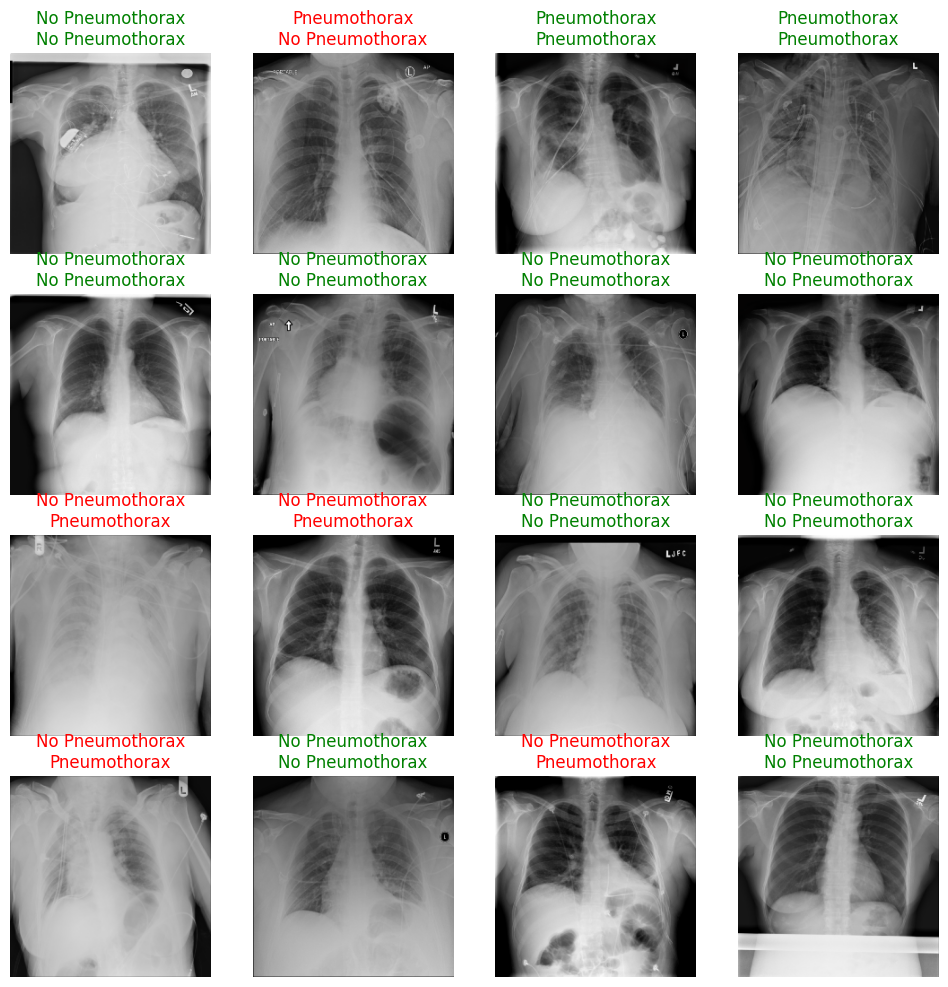

In [24]:
tta2 = learn2.tta(use_max=True)
learn2.show_results(max_n=16)

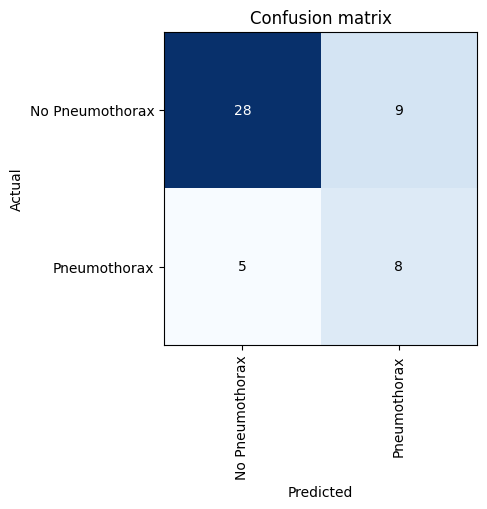

In [25]:
interp = ClassificationInterpretation.from_learner(learn)          # Initializing Interpretation for vision learner
losses, idxs = interp.top_losses()                                 # Initializing Top Losses. 
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(10, 5)) 

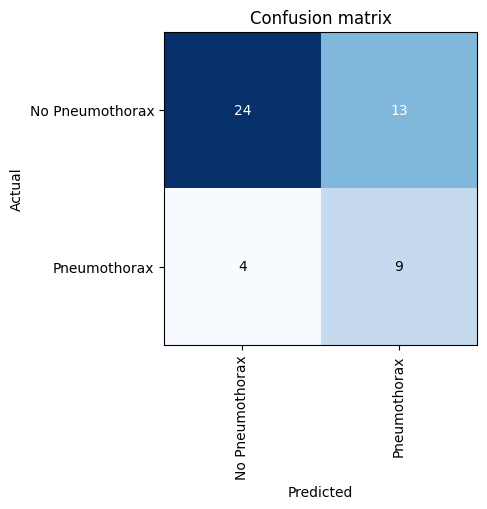

In [26]:

interp = ClassificationInterpretation.from_learner(learn2)          # Initializing Interpretation for cnn
losses, idxs = interp.top_losses()                                 # Initializing Top Losses. 
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(10, 5)) 

In [27]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print("for vision transformer : ", tn, fp, fn, tp)

for vision transformer :  24 13 4 9


In [28]:
#Sensitivity = True Positive/(True Positive + False Negative)
#It is also known as a Type I Error.
sensitivity = tp/(tp + fn)
sensitivity

0.6923076923076923

In [ ]:
'''In this case the model has a sensitivity of 70% and hence is only capable of correctly detecting 70% True Positives (i.e. who have Pneumothorax) 
but will miss 30% of False Negatives (patients that actually have Pneumothorax but were told they did not! Not a good situation to be in).'''

In [29]:
#Specificity = True Negative/(False Positive + True Negative)
#This is also known as a Type I error
specificity = tn/(fp + tn)
specificity  

0.6486486486486487

In [30]:
'''The model has a specificity of 65% and hence can correctly detect 65% of the time that a patient does not have Pneumothorax but will incorrectly 
classify that 35% of the patients have Pneumothorax (False Postive) but actually do not.'''

#Positive Predictive Value (PPV)
ppv = tp/(tp+fp)
ppv 

0.4090909090909091

In [31]:
#In this case the model performs quite bad in correctly predicting patients with Pneumothorax


#Negative Predictive Value (NPV)

npv = tn/(tn+fn)
npv

0.8571428571428571

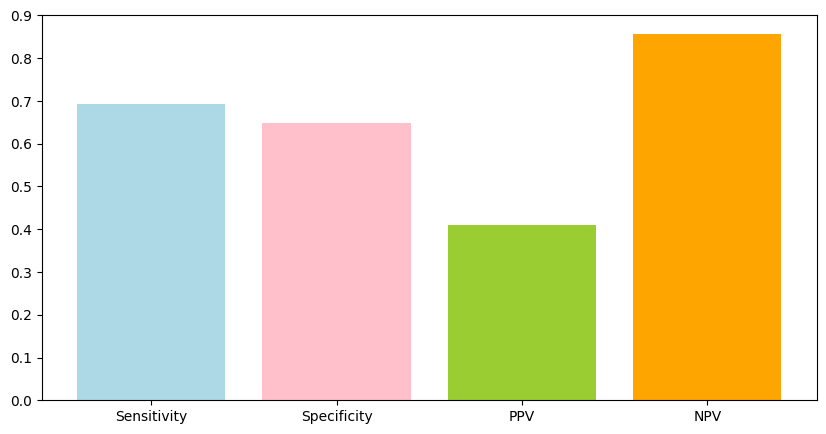

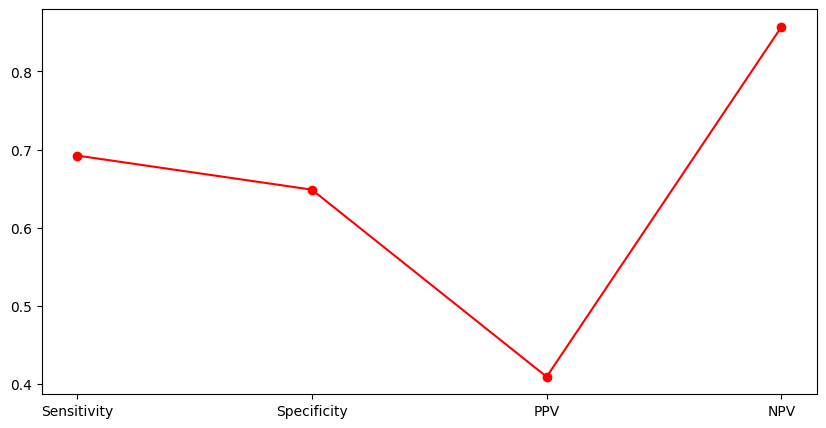

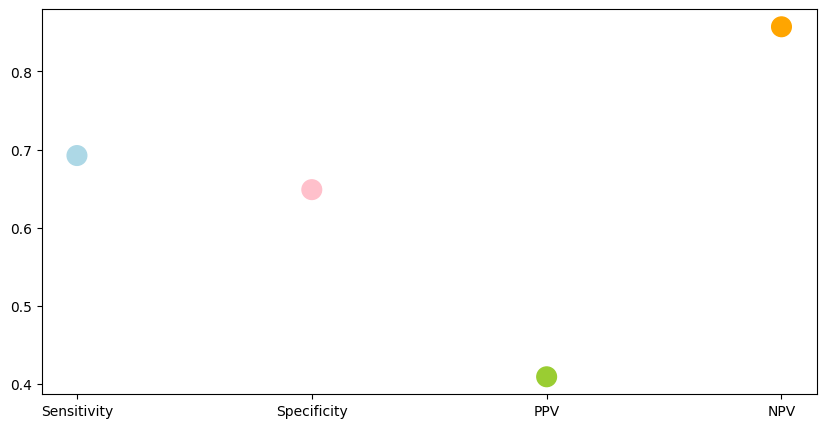

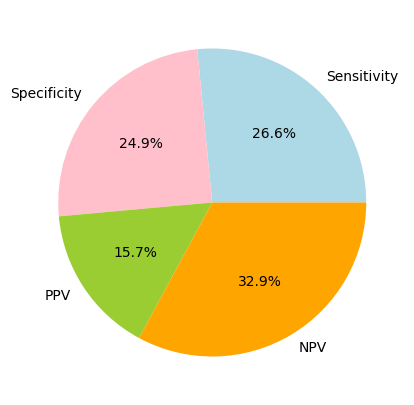

In [33]:
#This model is better at predicting patients with No Pneumothorax
colors = ['lightblue', 'pink', 'yellowgreen', 'orange']

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(['Sensitivity', 'Specificity', 'PPV', 'NPV'], [sensitivity, specificity, ppv, npv], color=colors)

# Create line chart
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(['Sensitivity', 'Specificity', 'PPV', 'NPV'], [sensitivity, specificity, ppv, npv], marker='o', color='red')

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(['Sensitivity', 'Specificity', 'PPV', 'NPV'], [sensitivity, specificity, ppv, npv], s=200, color=colors)

# Create pie chart
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie([sensitivity, specificity, ppv, npv], labels=['Sensitivity', 'Specificity', 'PPV', 'NPV'], colors=colors, autopct='%1.1f%%')
plt.show()
